<a href="https://colab.research.google.com/github/Prasang-Biyani/OTT-Movie-Recommendations/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#```Problem Statement```

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
movies = pd.read_csv('movies.csv')
users = pd.read_csv('users.csv')
ratings = pd.read_csv('ratings.csv')

In [ ]:
# movies - 
movies[["MovieID", "Title", "Genres"]] = movies["Movie ID::Title::Genres"].str.split("::", expand=True)
movies = movies.drop(["Movie ID::Title::Genres"], axis=1)

# users - 
users[["UserID", "Gender", "Age", "Occupation", "Zip"]] = users["UserID::Gender::Age::Occupation::Zip-code"].str.split("::", expand=True)
users = users.drop(["UserID::Gender::Age::Occupation::Zip-code"], axis=1)

# ratings - 
ratings[["UserID", "MovieID", "Rating", "Timestamp"]] = ratings["UserID::MovieID::Rating::Timestamp"].str.split("::", expand=True)
ratings = ratings.drop(["UserID::MovieID::Rating::Timestamp"], axis=1)

In [ ]:
df = ratings.merge(users, on=["UserID"]).merge(movies, on=["MovieID"])

In [ ]:
df['UserID'] = df['UserID'].astype(int)
df['MovieID'] = df['MovieID'].astype(int)
df['Occupation'] = df['Occupation'].astype(int)
df['Timestamp'] = df['Timestamp'].astype(int)

In [ ]:
df.shape

(1000209, 10)

In [ ]:
df.columns

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Gender', 'Age',
       'Occupation', 'Zip', 'Title', 'Genres'],
      dtype='object')

##<font color="red" face='georgia'>Features Description</font>

Dataset consists of 1000209 data points with 10 features. 

Following are the description of features:

1. UserID : Unique User ID.
2. MovieID : Unique Movie ID.
3. Rating : Ratings are made on a 5-star scale (whole-star ratings only)
4. Timestamp : Timestamp is represented in seconds
5. Gender : Gender is denoted by a "M" for male and "F" for female
6. Age : Age is chosen from the following ranges
  1: "Under 18"
  18: "18-24"
  25: "25-34"
  35: "35-44"
  45: "45-49"
  50: "50-55"
  56: "56+"
7. Occupation: Multiple occupations are present in the dataset.
8. Zip: Zipcode of the users' city.
9. Title: Titles are identical to titles provided by the IMDB (including year of release)
10. Genres: Genres are pipe-separated and are selected from the following genres.



In [ ]:
df.dtypes

UserID         int64
MovieID        int64
Rating        object
Timestamp      int64
Gender        object
Age           object
Occupation     int64
Zip           object
Title         object
Genres        object
dtype: object

In [ ]:
for column in df.columns:
  print(f'{column} : {len(df[column].unique())}')

UserID : 6040
MovieID : 3706
Rating : 5
Timestamp : 458455
Gender : 2
Age : 7
Occupation : 21
Zip : 3439
Title : 3706
Genres : 359


In [ ]:
df.isna().sum()

UserID           0
MovieID          0
Rating           0
Timestamp        0
Gender           0
Age              0
Occupation       0
Zip              0
Title            0
Genres        4065
dtype: int64

##<font color="red" face='georgia'>Observations</font>

There are missing values except in Genres.

##<font color="red" face='georgia'>Handling Missing Values</font>

In [ ]:
# Removing missing genres - 
df = df[~df['Genres'].isna()]

In [ ]:
df.isna().sum()

UserID        0
MovieID       0
Rating        0
Timestamp     0
Gender        0
Age           0
Occupation    0
Zip           0
Title         0
Genres        0
dtype: int64

In [ ]:
df.duplicated().sum()

0

There are no missing values.

In [ ]:
# There are some genres which are blank
df = df[df['Genres'] != ""]

#```Feature Engineering - I```

In [ ]:
# pd.to_datetime(df['Timestamp']).dt.year.value_counts(normalize=True)
import re
df['Release_Year'] = df['Title'].str.extract("\(([\d]+)\)")[0]
df['Title'] = df['Title'].apply(lambda x: re.sub("\(([\d]+)\)", "", x))

In [ ]:
# User average rating
df = df.merge(df.groupby('UserID')['Rating'].mean().round(3).reset_index().rename({"Rating":"UserAvgRating"}, axis=1).replace({np.inf: 5}), on="UserID")
# Movie average rating
df = df.merge(df.groupby('MovieID')['Rating'].mean().round(3).reset_index().rename({"Rating":"MovieAvgRating"}, axis=1).replace({np.inf: 5}), on="MovieID")

In [ ]:
df['Rating'].value_counts(normalize=True)

4    0.349107
3    0.261482
5    0.225508
2    0.107676
1    0.056227
Name: Rating, dtype: float64

##<font color="red" face='georgia'>Observations</font>

The majority of the ratings given by the user are 4, contributing 35%, followed by 3 and 5 stars, resulting in 26% and 22.5%, respectively.

In [ ]:
df['Release_Year'].value_counts(normalize=True)

1999    0.087170
1998    0.068420
1997    0.065656
1995    0.060635
1996    0.059501
          ...   
1919    0.000045
1929    0.000043
1928    0.000027
1920    0.000024
1923    0.000017
Name: Release_Year, Length: 81, dtype: float64

##<font color="red" face='georgia'>Observations</font>

The majority of the movies contained in the dataset is from 1999, contributing 8.7%, followed by 1998 and 1997, resulting in 6.8% and 6.5%, respectively.

In [ ]:
df['Genres'].value_counts(normalize=True)

Comedy              0.117144
Drama               0.111386
Comedy|Romance      0.042357
Comedy|Drama        0.041838
Drama|Romance       0.028209
                      ...   
Horr                0.000003
Come                0.000003
Documen             0.000002
Film-Noir|Horror    0.000002
Fantasy             0.000001
Name: Genres, Length: 357, dtype: float64

##<font color="red" face='georgia'>Observations</font>

The most popular genre in the dataset is comedy, contributing 11.7%, followed by Drama and Comedy|Romance, resulting in 11.1% and 4.2%, respectively.

In [ ]:
df['Occupation'].value_counts(normalize=True)

4     0.131132
0     0.130503
7     0.105420
1     0.085266
17    0.072815
20    0.060328
12    0.057152
2     0.050016
14    0.049142
16    0.045992
6     0.037183
3     0.031642
10    0.023328
15    0.022910
5     0.021866
11    0.020541
19    0.014899
13    0.013710
18    0.012097
9     0.011356
8     0.002702
Name: Occupation, dtype: float64

##<font color="red" face='georgia'>Observations</font>

The majority of the subscribers are students who are going to college, followed by "other" and executives and managers.

In [ ]:
df['Gender'].value_counts(normalize=True)

M    0.753495
F    0.246505
Name: Gender, dtype: float64

##<font color="red" face='georgia'>Observations</font>

Majority of the subscribers are males, resulting in 75% of the viewers.

In [ ]:
df['Age'].value_counts(normalize=True)

25    0.395629
35    0.198851
18    0.183756
45    0.083484
50    0.072351
56    0.038693
1     0.027237
Name: Age, dtype: float64

##<font color="red" face='georgia'>Observations</font>

Majority of the subscribers belong to age group of 25-34, followed by 35-44 and 18-24.

In [ ]:
df.groupby('Gender')['Rating'].value_counts(normalize=True)

Gender  Rating
F       4         0.353282
        3         0.255718
        5         0.237098
        2         0.099690
        1         0.054213
M       4         0.347742
        3         0.263367
        5         0.221716
        2         0.110289
        1         0.056886
Name: Rating, dtype: float64

##<font color="red" face='georgia'>Observations</font>

1. The majority of the rating given by females is 4, contributing to 35%, followed by 3 and 5, resulting in 25% and 23.7%, respectively.
2. The majority of the rating given by men is 4, contributing to 34.7%, followed by 3 and 5, resulting in 26% and 22%, respectively.

In [ ]:
df.groupby('Age')['Rating'].value_counts(normalize=True)

Age  Rating
1    4         0.323787
     5         0.249337
     3         0.234631
     2         0.109797
     1         0.082449
18   4         0.328431
     3         0.259590
     5         0.220442
     2         0.120358
     1         0.071179
25   4         0.346062
     3         0.263930
     5         0.216090
     2         0.113436
     1         0.060482
35   4         0.362027
     3         0.266688
     5         0.223796
     2         0.101887
     1         0.045602
45   4         0.363007
     3         0.267217
     5         0.227907
     2         0.100997
     1         0.040873
50   4         0.365709
     5         0.255512
     3         0.255234
     2         0.082877
     1         0.040668
56   4         0.368835
     5         0.276600
     3         0.236878
     2         0.077602
     1         0.040085
Name: Rating, dtype: float64

##<font color="red" face='georgia'>Observations</font>

1. All the age groups have given 4 star as most frequent rating.
2. All the age groups have given 1 star as least frequent rating.

In [ ]:
df.groupby('Genres')['Rating'].value_counts(normalize=True)

Genres   Rating
A        1         0.358566
         2         0.294821
         3         0.243028
         4         0.067729
         5         0.035857
                     ...   
Western  4         0.407629
         5         0.277553
         3         0.232554
         2         0.055018
         1         0.027246
Name: Rating, Length: 1754, dtype: float64

#```Univariate Analysis```

In [ ]:
!pip3 install SciencePlots

In [ ]:
!sudo apt install msttcorefonts -qq --yes
!rm ~/.cache/matplotlib -rf

In [ ]:
# https://github.com/garrettj403/SciencePlots/wiki/Gallery#color-cycles

import scienceplots
import matplotlib
import shutil

plt.style.use(['science', 'notebook', 'nature'])
plt.rcParams.update({'figure.dpi': '200'})
font = {'weight' : 'bold',
        'size'   : 22}

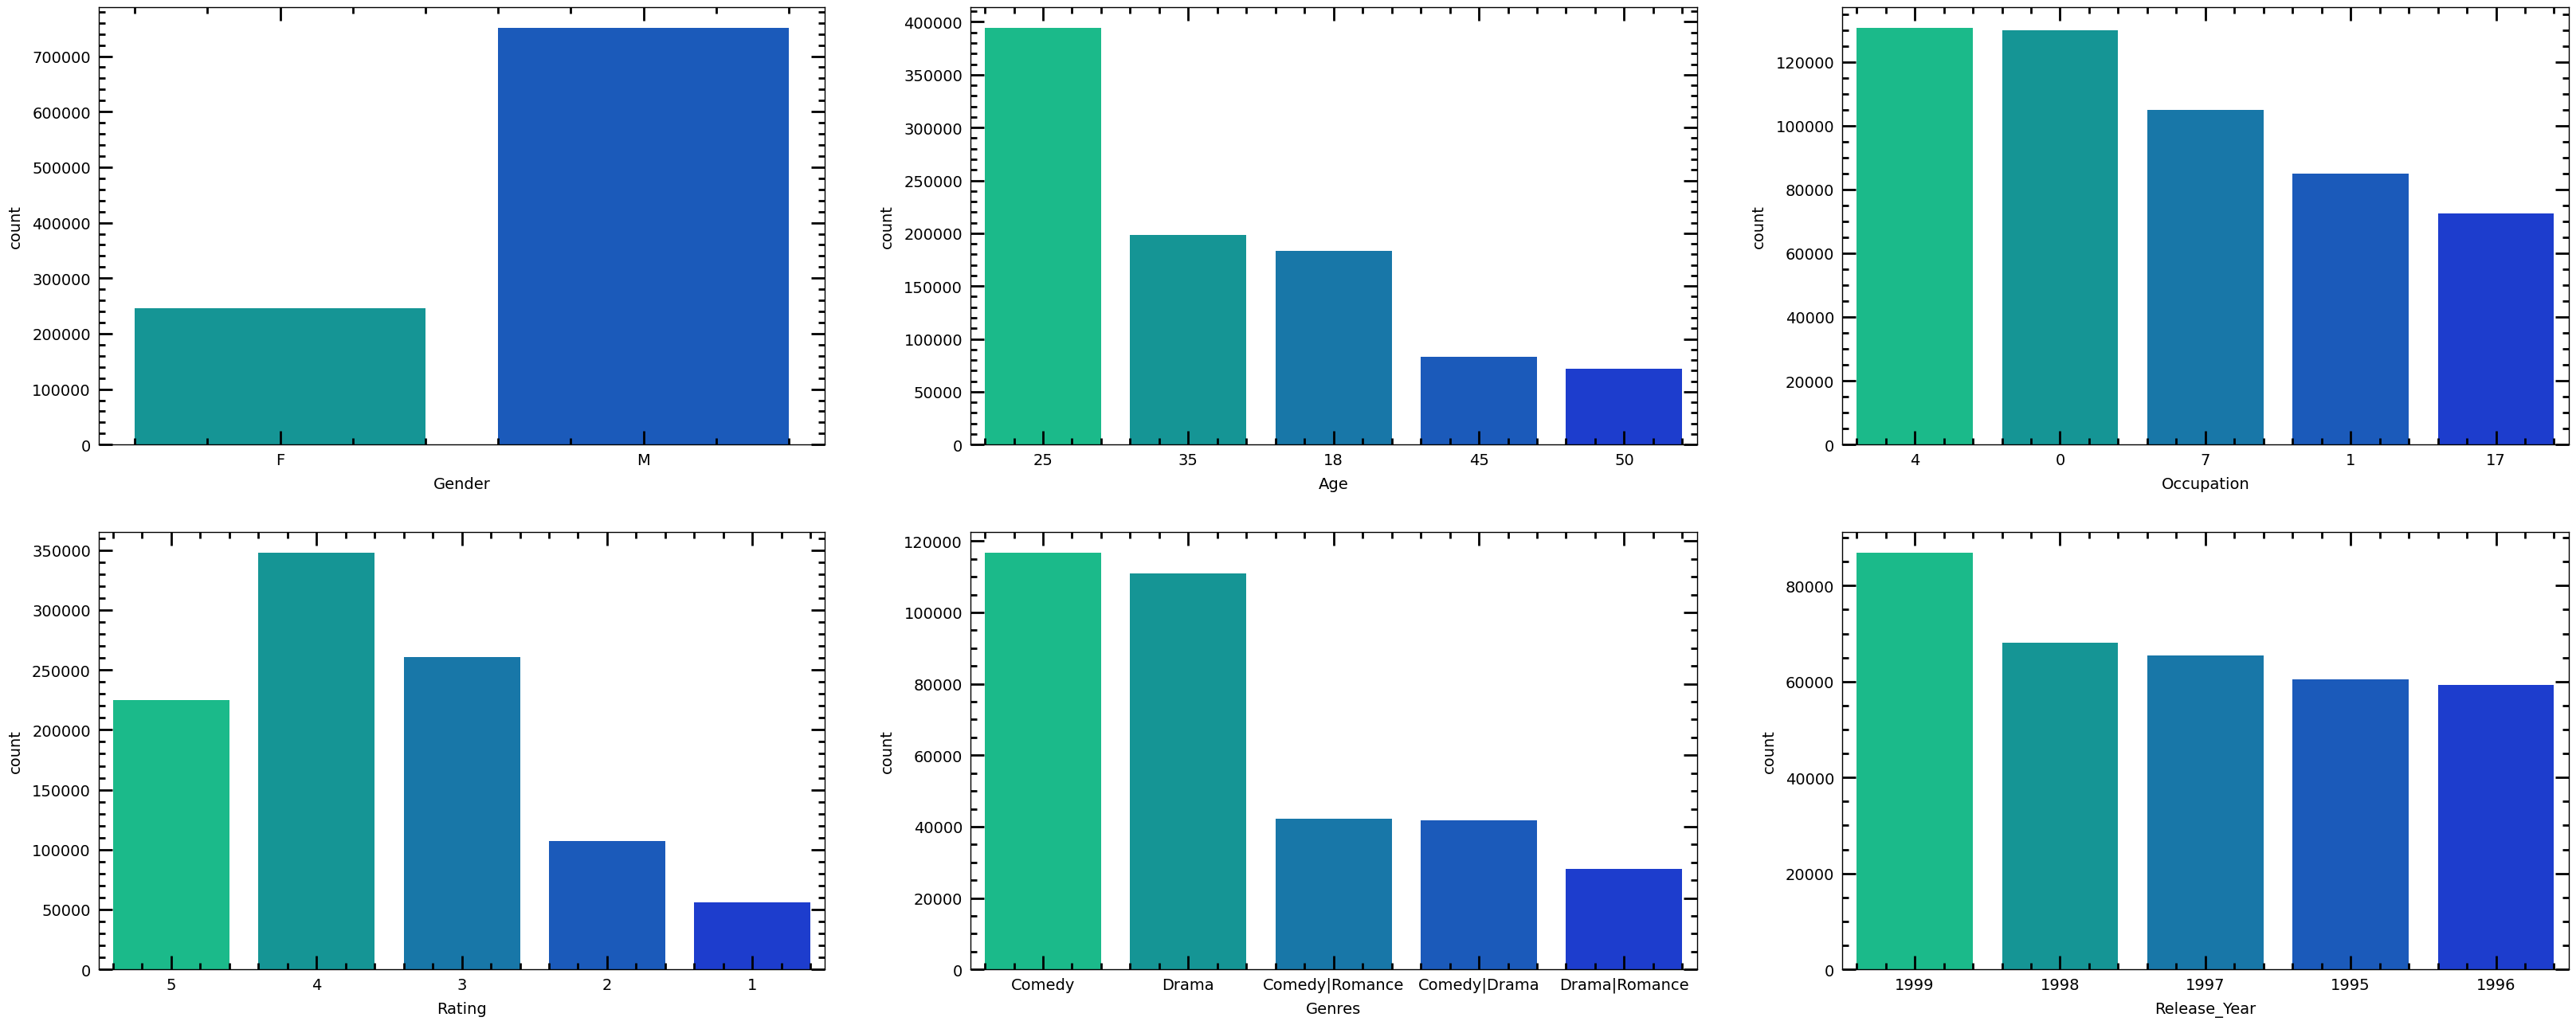

In [ ]:
categorical_columns = ['Gender', 'Age', 'Occupation', 'Rating', 'Genres', 'Release_Year']
colors = ['r','g','b','y','c']
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
axes = ax.ravel()
for index, feature in enumerate(categorical_columns):
  number = np.random.randint(0, len(colors))
  if len(df[feature].unique()) > 5:
    sns.countplot(data=df, x=feature, ax=axes[index], color=colors[number], 
                  order=df[feature].value_counts().index[:5], palette="winter_r")
  else:
    sns.countplot(data=df, x=feature, ax=axes[index], color=colors[number], palette="winter_r")

##<font color="red" face='georgia'>Observations</font>

##```Gender```

There are approximately 7.5 lakh male subscribers and 2.5 lakh female subscribers.

##```Age```

The majority of the subscribers belong to the age group of 25–34, followed by 35–44 and 18–24.

##```Occupation```

The proportion of college/grad students and others is nearly identical, followed by executives/managers and academics/educators.

##```Genres```

Comedy and drama are the most popular genres among the subscribers.

##```Release Year```

The majority of the movies were released in 1999, followed by 1998 and 1997.

##```Rating```

The majority of the viewers have given it a rating of 4 stars, followed by 3 and 5.


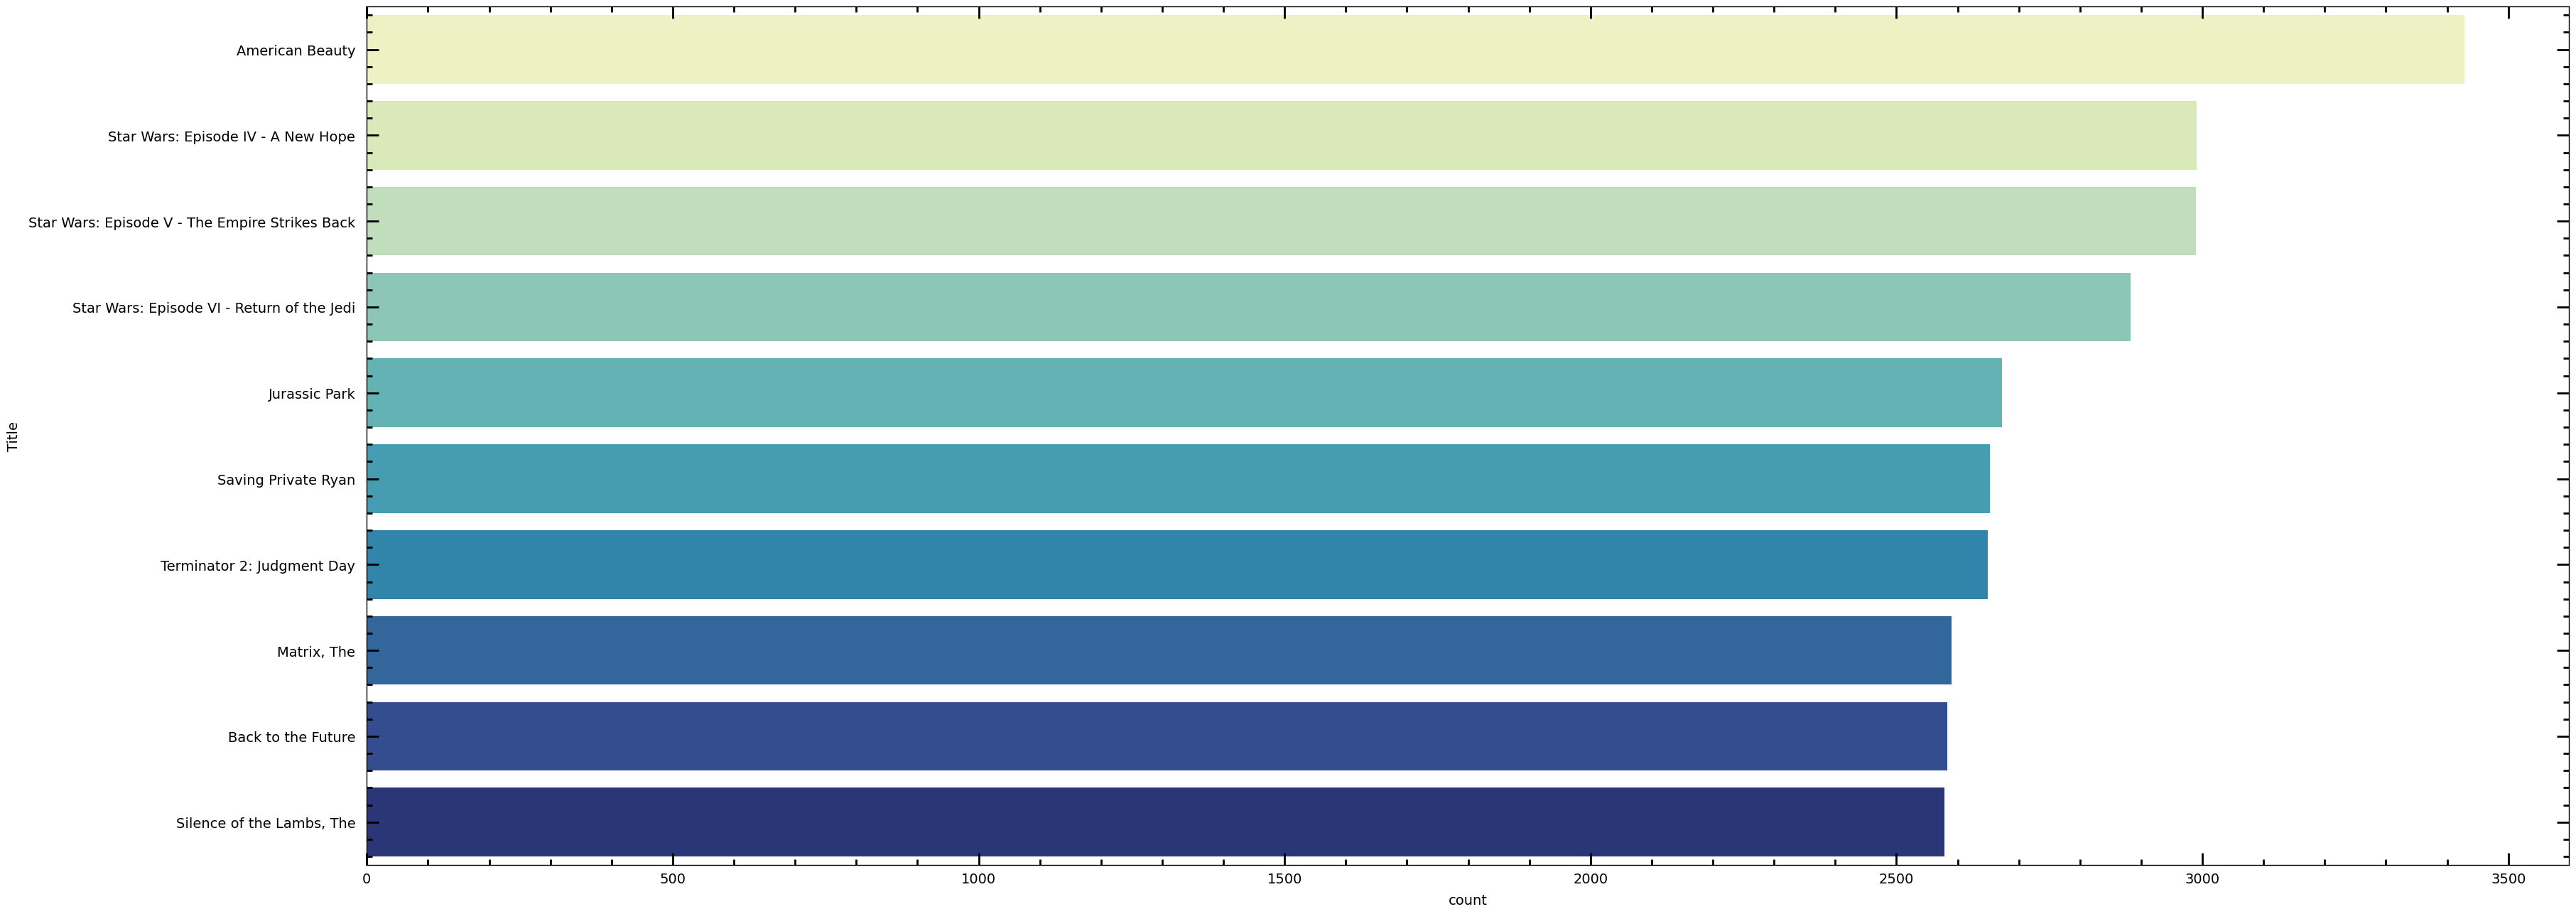

In [ ]:
fig = plt.figure(figsize=(20, 8))
sns.countplot(data=df, y="Title", order=df['Title'].value_counts().index[0:10], palette="YlGnBu")
plt.show()

##<font color="red" face='georgia'>Observations</font>

America's Best Beauty and Star Wars: Episode IV: A New Hope, followed by Star Wars: Episode V, are the most-rated movies.

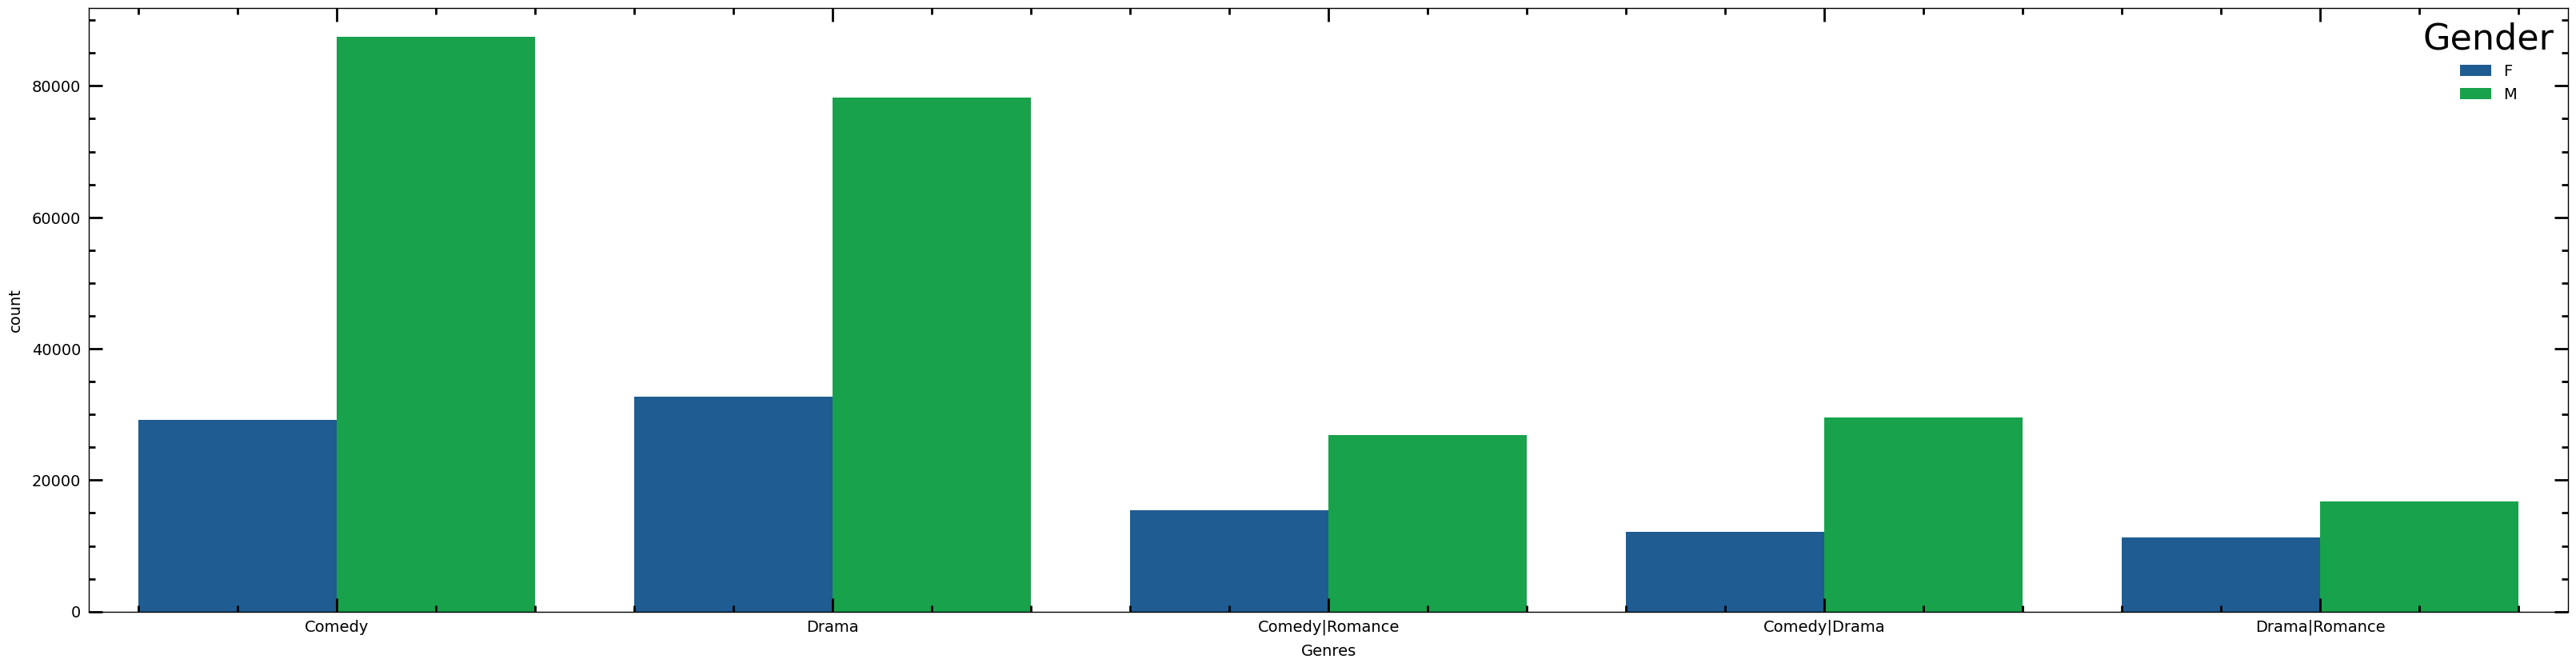

In [ ]:
# Gender vs Genres - 
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Genres", order=df['Genres'].value_counts().index[:5], hue="Gender")
plt.show()
# Ratings vs Gender

##<font color="red" face='georgia'>Observations</font>

1. The majority of male and female viewers have seen comedies, followed by dramas.
2. Among female viewers, the ratio of Comedy|Drama to Drama|Romance is nearly one.
3. The ratio of comedy/drama to comedy/romance among the male viewers is nearly one.

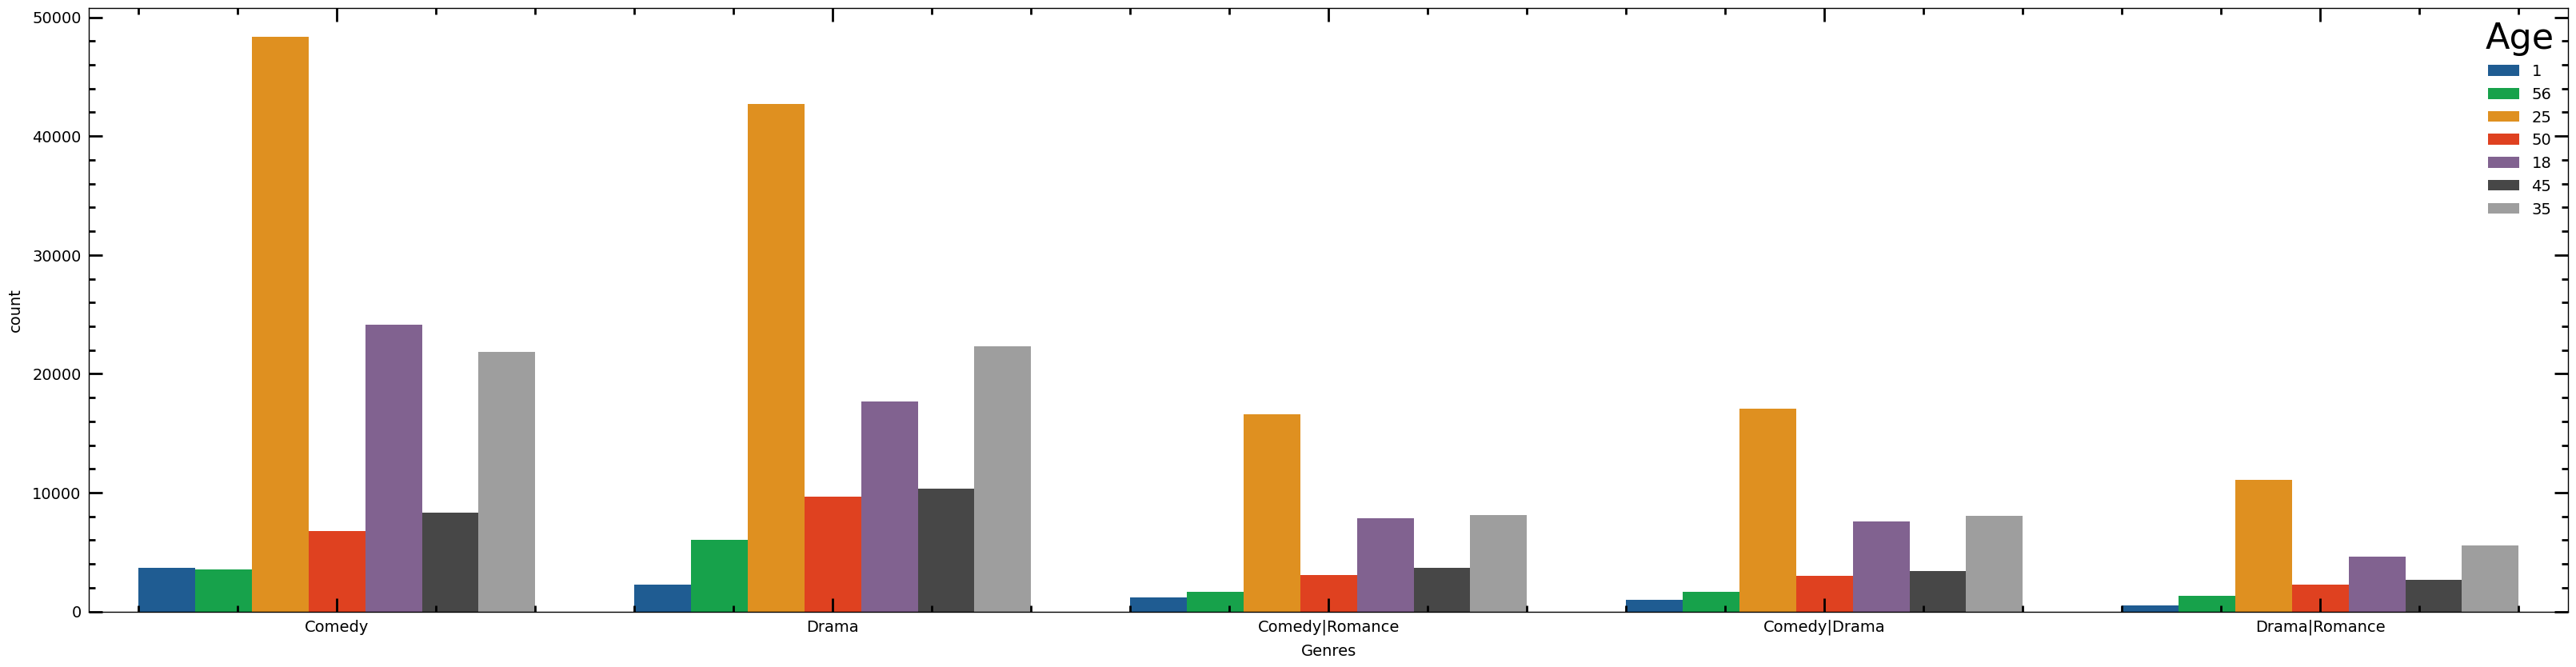

In [ ]:
# Age vs Genres - 
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Genres", order=df['Genres'].value_counts().index[:5], hue="Age")
plt.show()

##<font color="red" face='georgia'>Observations</font>

1. The comedy genre is popular among the age groups of 25–34, 18–24, and 35–44. The ratio of comedy to drama is nearly 1 for the 35–44 age group.
2. Drama|Romance is the most popular genre, followed by Comedy|Drama, and Comedy|Romance is the least popular among those aged 18 to 56.
3. Drama/romance is least popular among the 50-55 age group.
4. Among other genres, drama is most popular in the age group of 45–54.

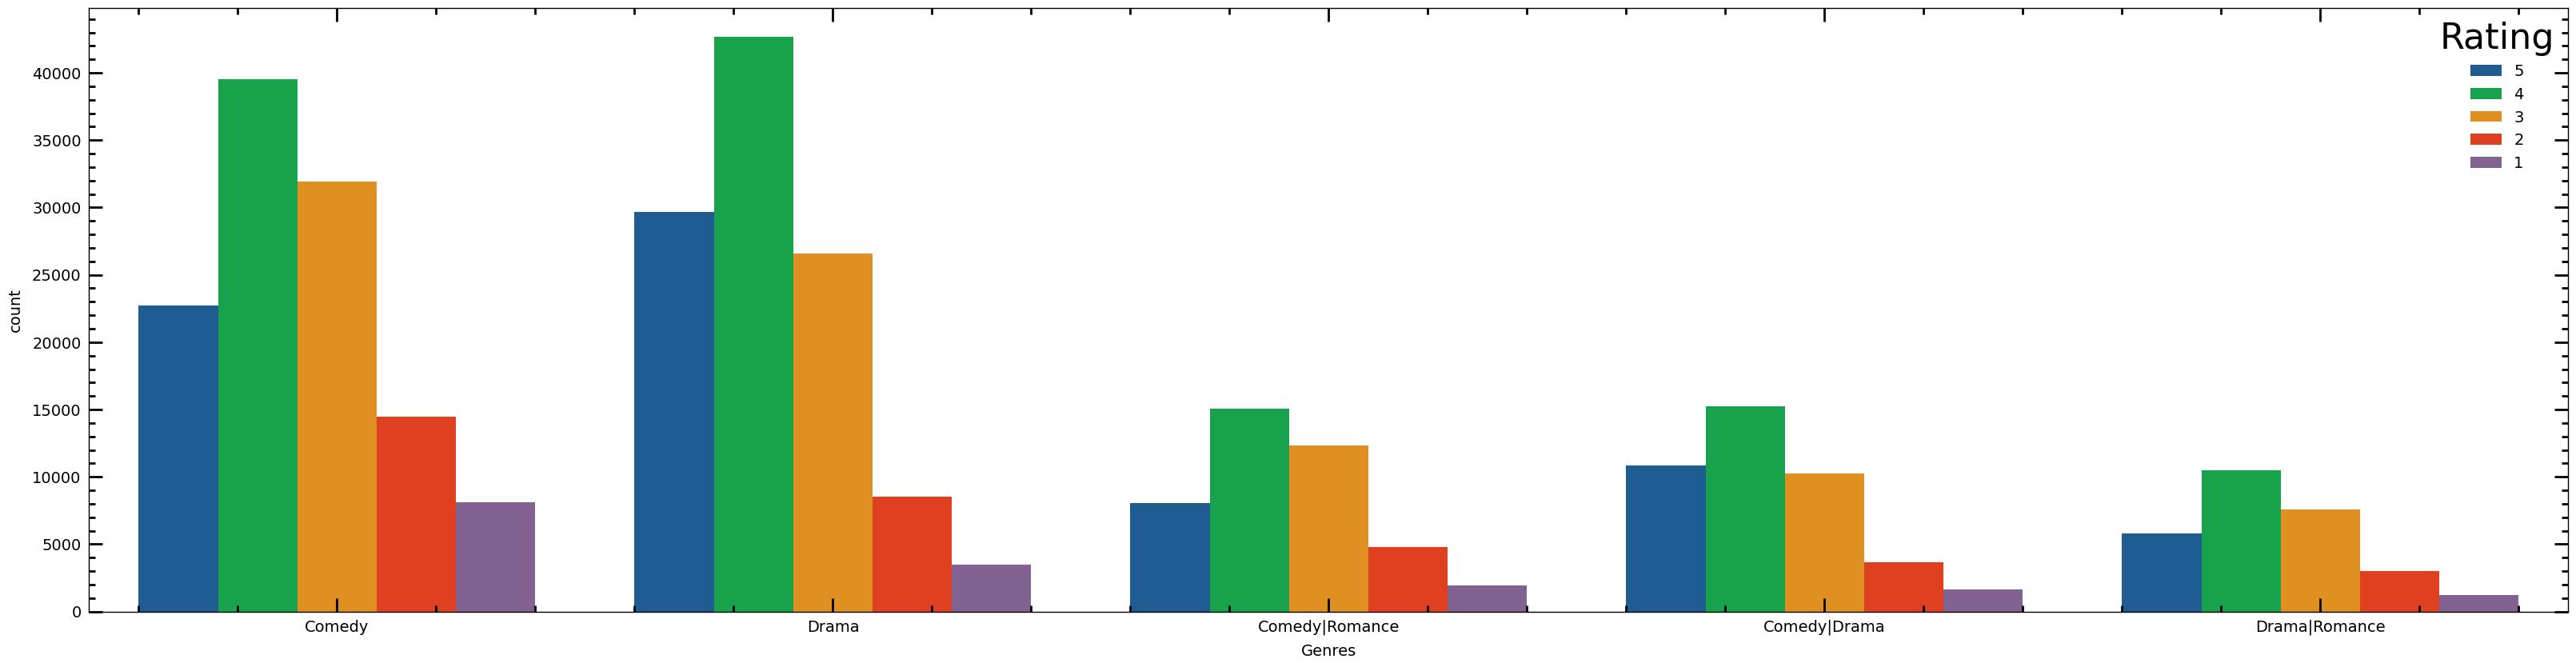

In [ ]:
# Ratings vs Genres - 
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Genres", order=df['Genres'].value_counts().index[:5], hue="Rating")
plt.show()

##<font color="red" face='georgia'>Observations</font>

1. Drama is the most popular genre, with a majority of 4 and 5-star ratings, followed by comedy.
2. The ratio of 3 to 5 star ratings in comedy or romance is nearly one.
3. The ratio of 4 star ratings in comedy/romance and comedy/drama is nearly one.

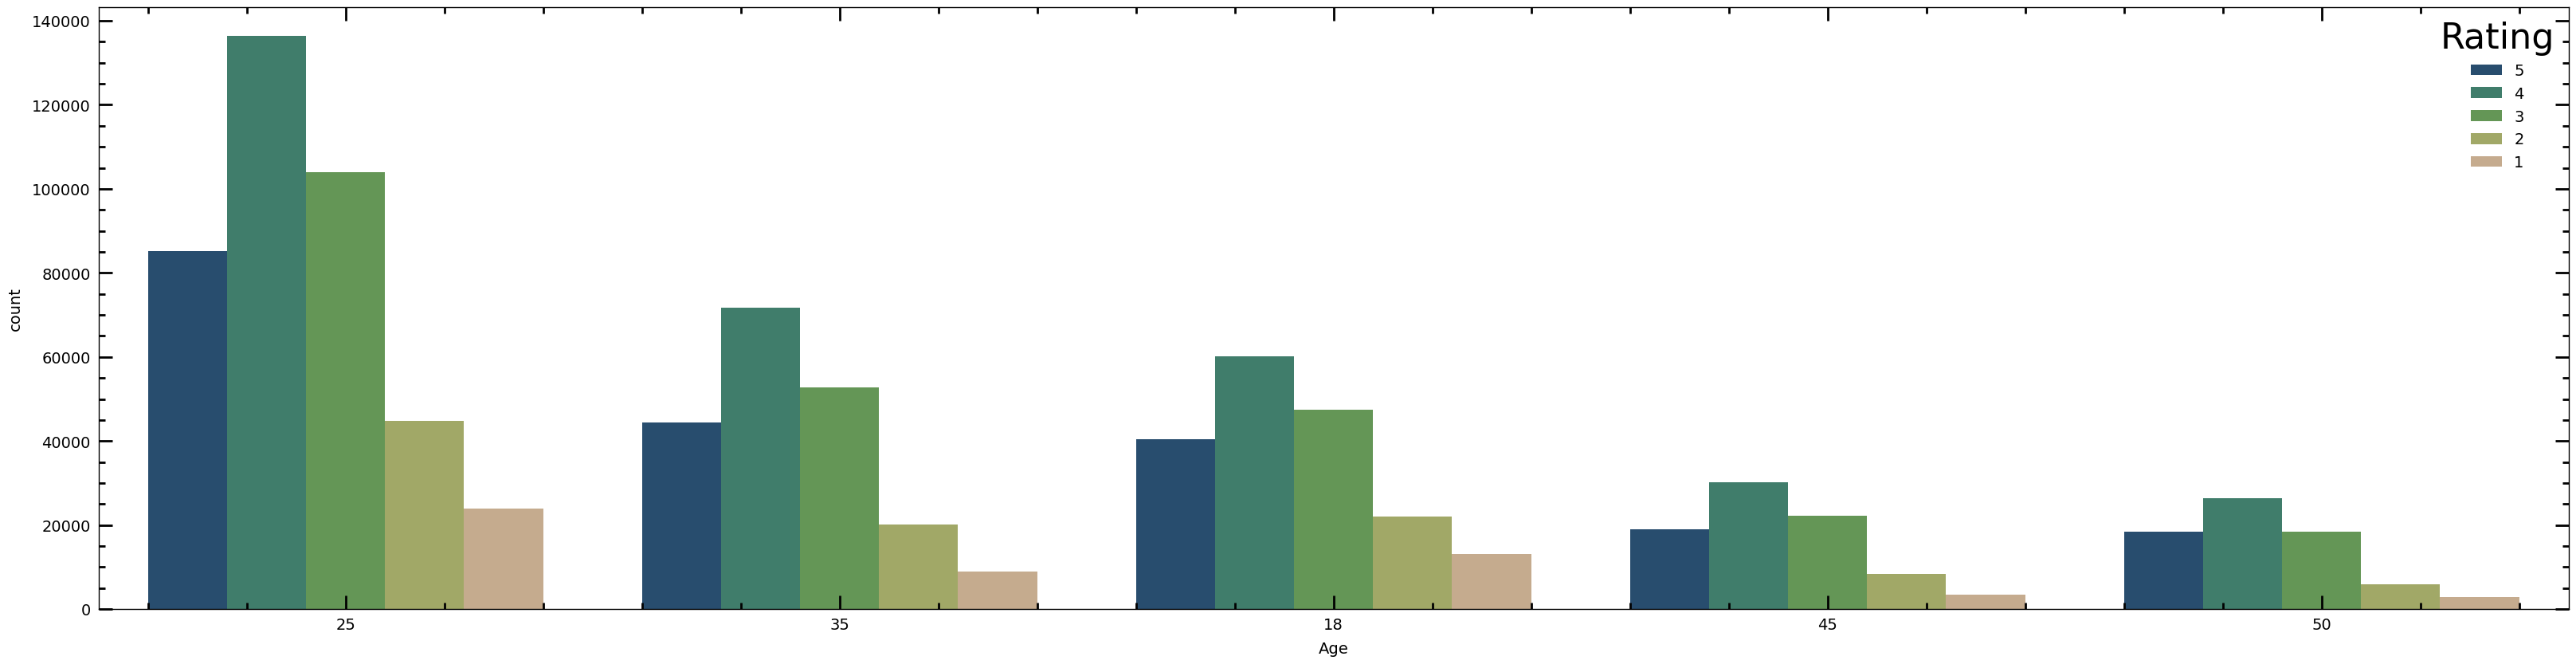

In [ ]:
# Ratings vs Age -  
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Age", order=df['Age'].value_counts().index[:5], hue="Rating", palette="gist_earth")
plt.show()

##<font color="red" face='georgia'>Observations</font>

1. The most frequent rating given by all the age groups is 4, followed by 3 and 5, respectively.
2. The ratio of 1 to 2 star ratings is nearly one between the age groups of 45–54 and 50–55.

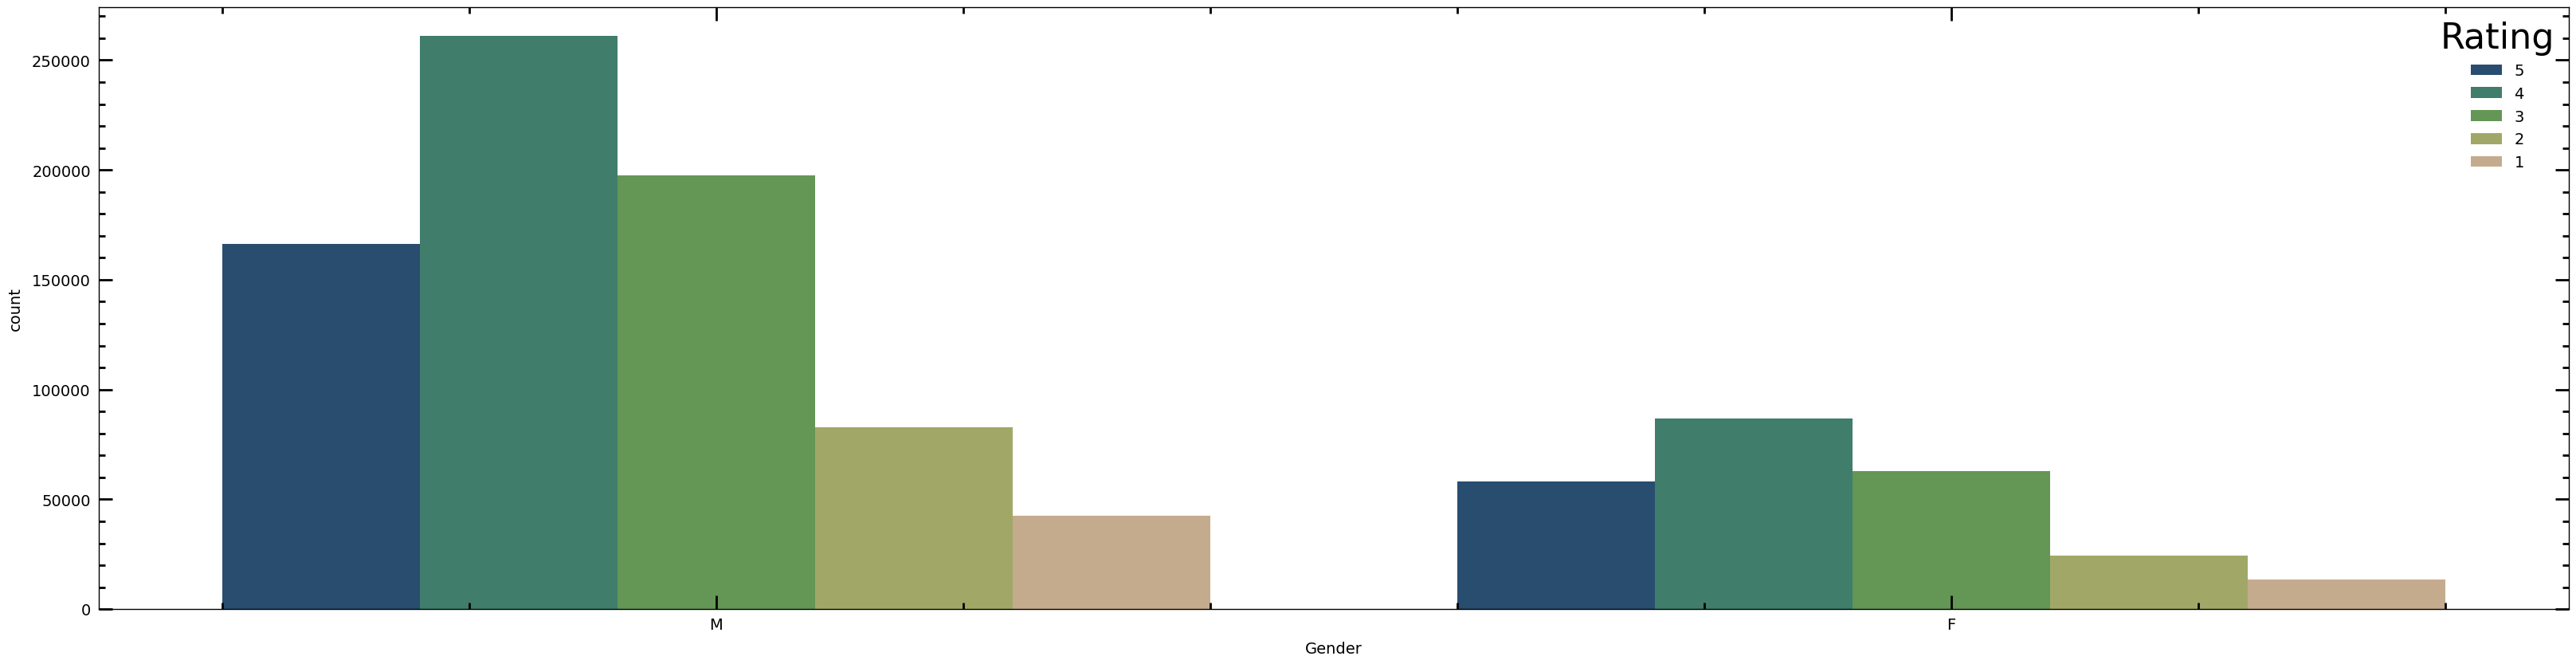

In [ ]:
# Ratings vs Genres -
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Gender", order=df['Gender'].value_counts().index[:2], hue="Rating", palette="gist_earth")
plt.show()

##<font color="red" face='georgia'>Observations</font>

The majority of the ratings given by both genders are 4 stars, followed by 3 and 5 stars.


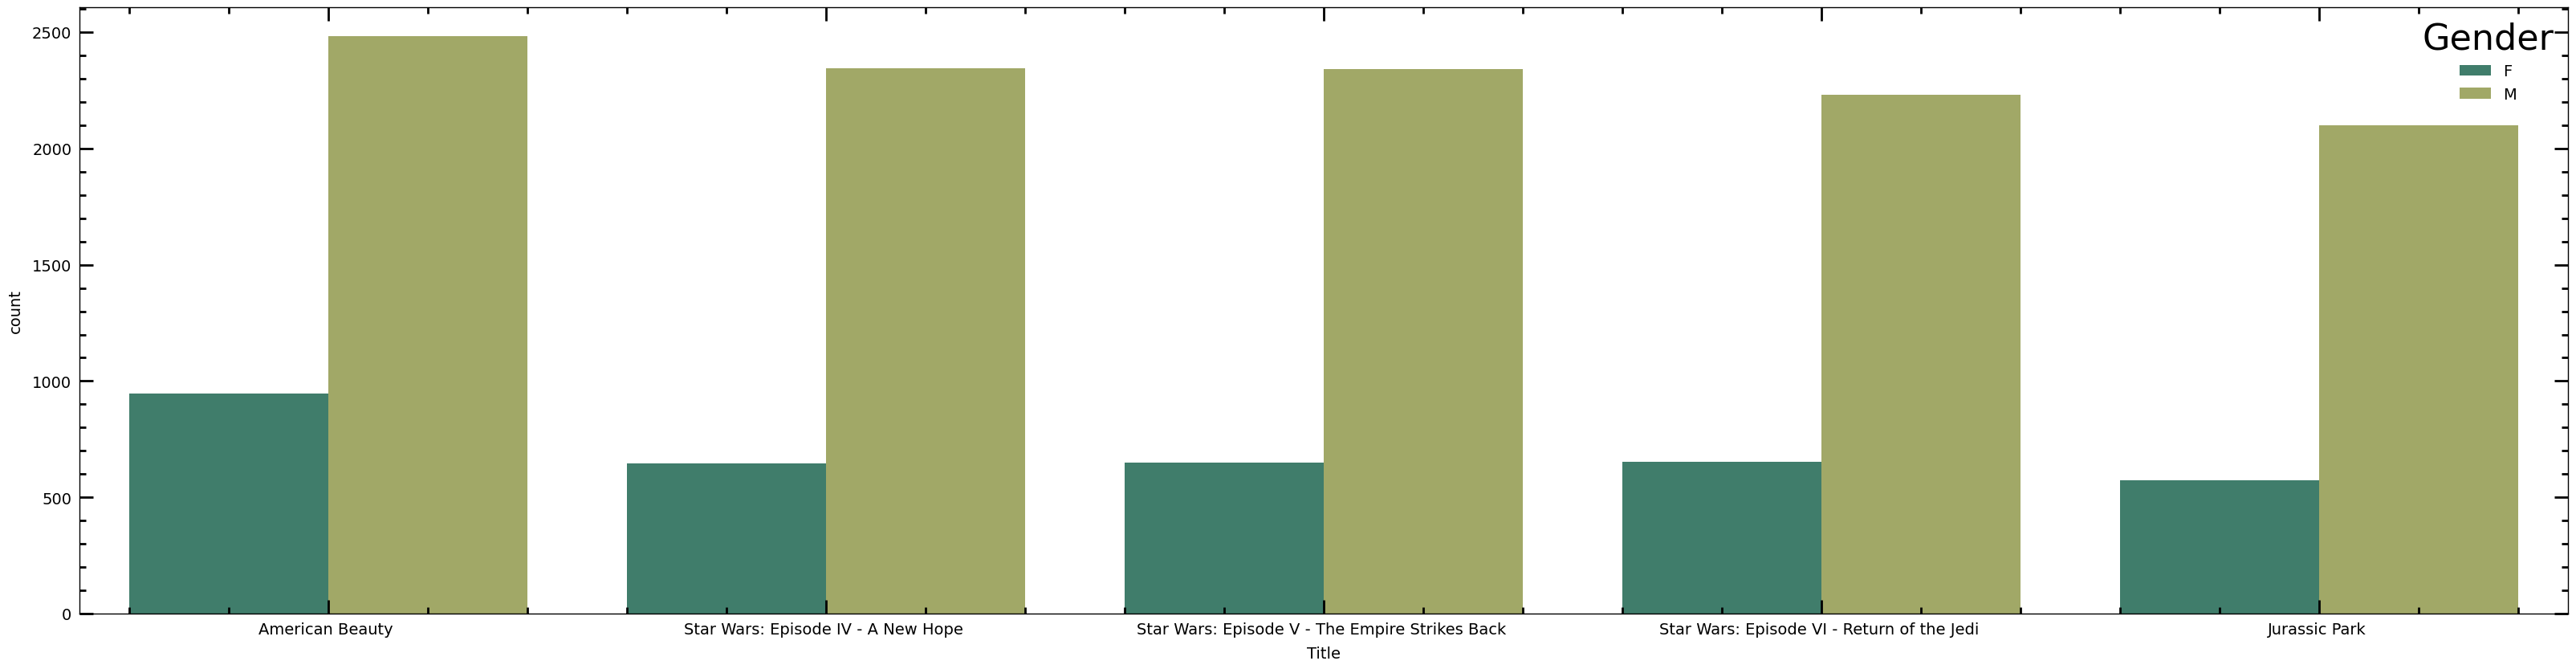

In [ ]:
# Title vs Gender -
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Title", order=df['Title'].value_counts().index[:5], hue="Gender", palette="gist_earth")
plt.show()

##<font color="red" face='georgia'>Observations</font>

1. American Beauty is the most watched film by both genders.
2. Stars Episode IV, V, VI, and Jurassic Park are watched in equal proportion by female subscribers.
3. Stars Episodes IV and V are watched in equal proportion by male subscribers.

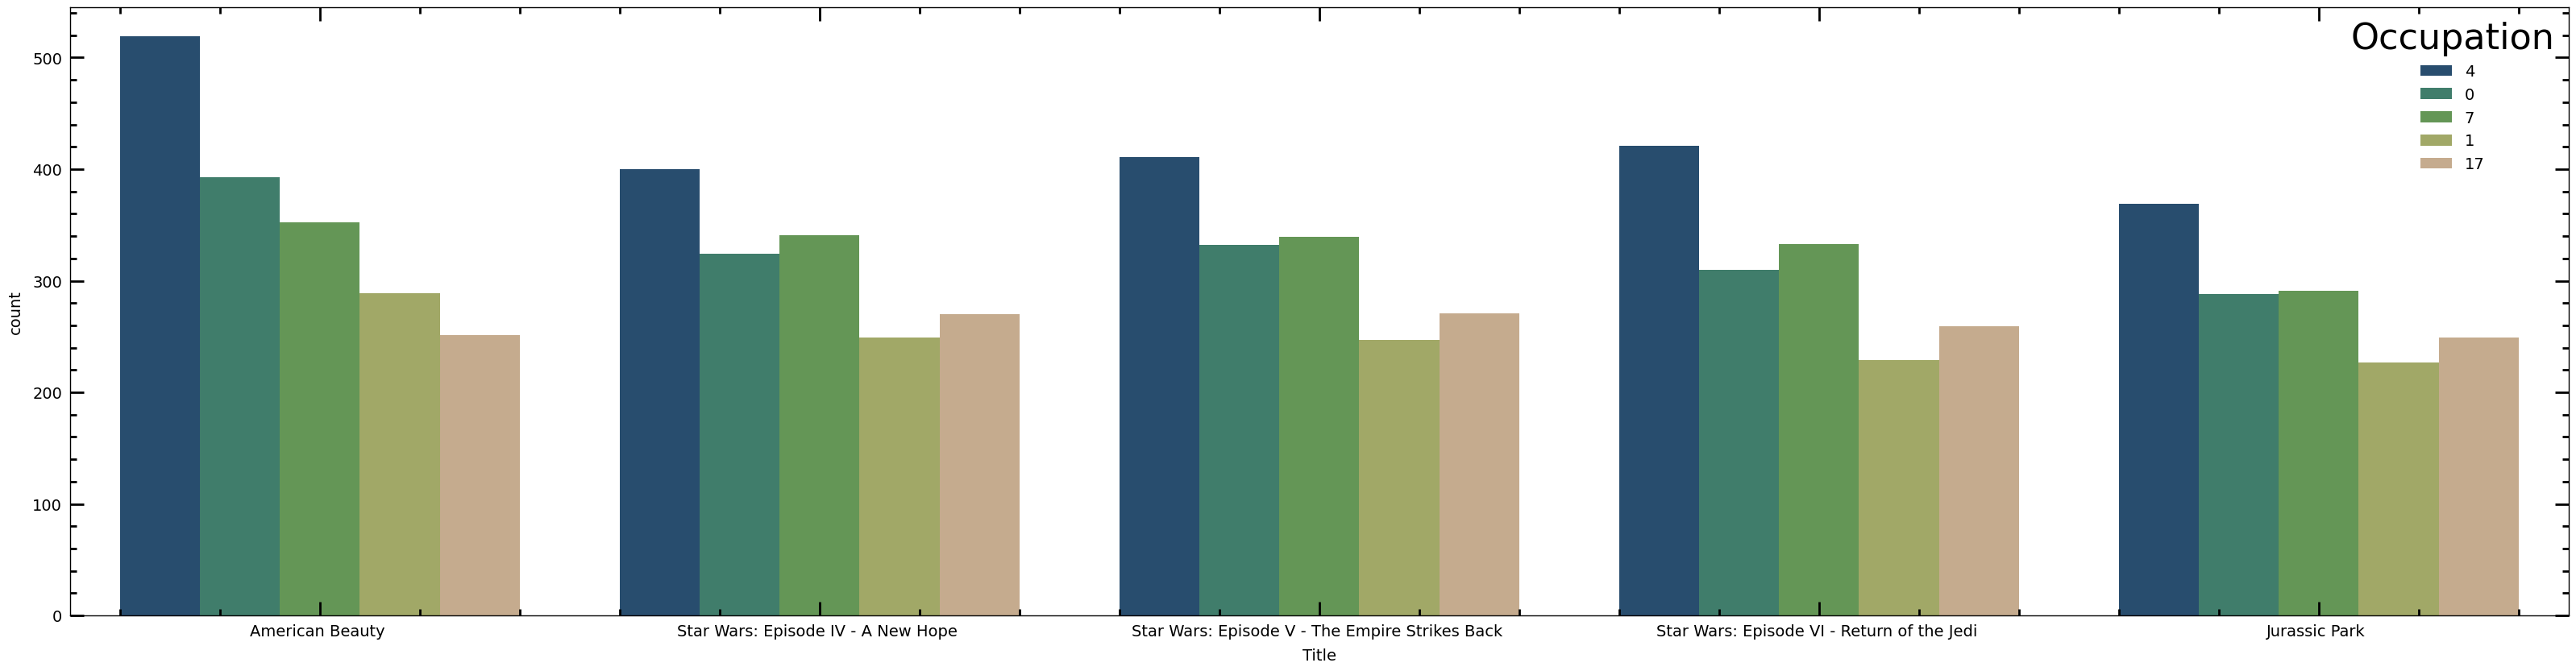

In [ ]:
# Title vs Gender -
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Title", order=df['Title'].value_counts().index[:5], hue="Occupation", palette="gist_earth", hue_order=df['Occupation'].value_counts().index[:5])
plt.show()

##<font color="red" face='georgia'>Observations</font>

1. American Beauty is the most watched film by college/grad student, "other", and "executives/managerials".
2. Stars Episode IV, V, VI, and Jurassic Park are watched in equal proportion by technician/engineer.

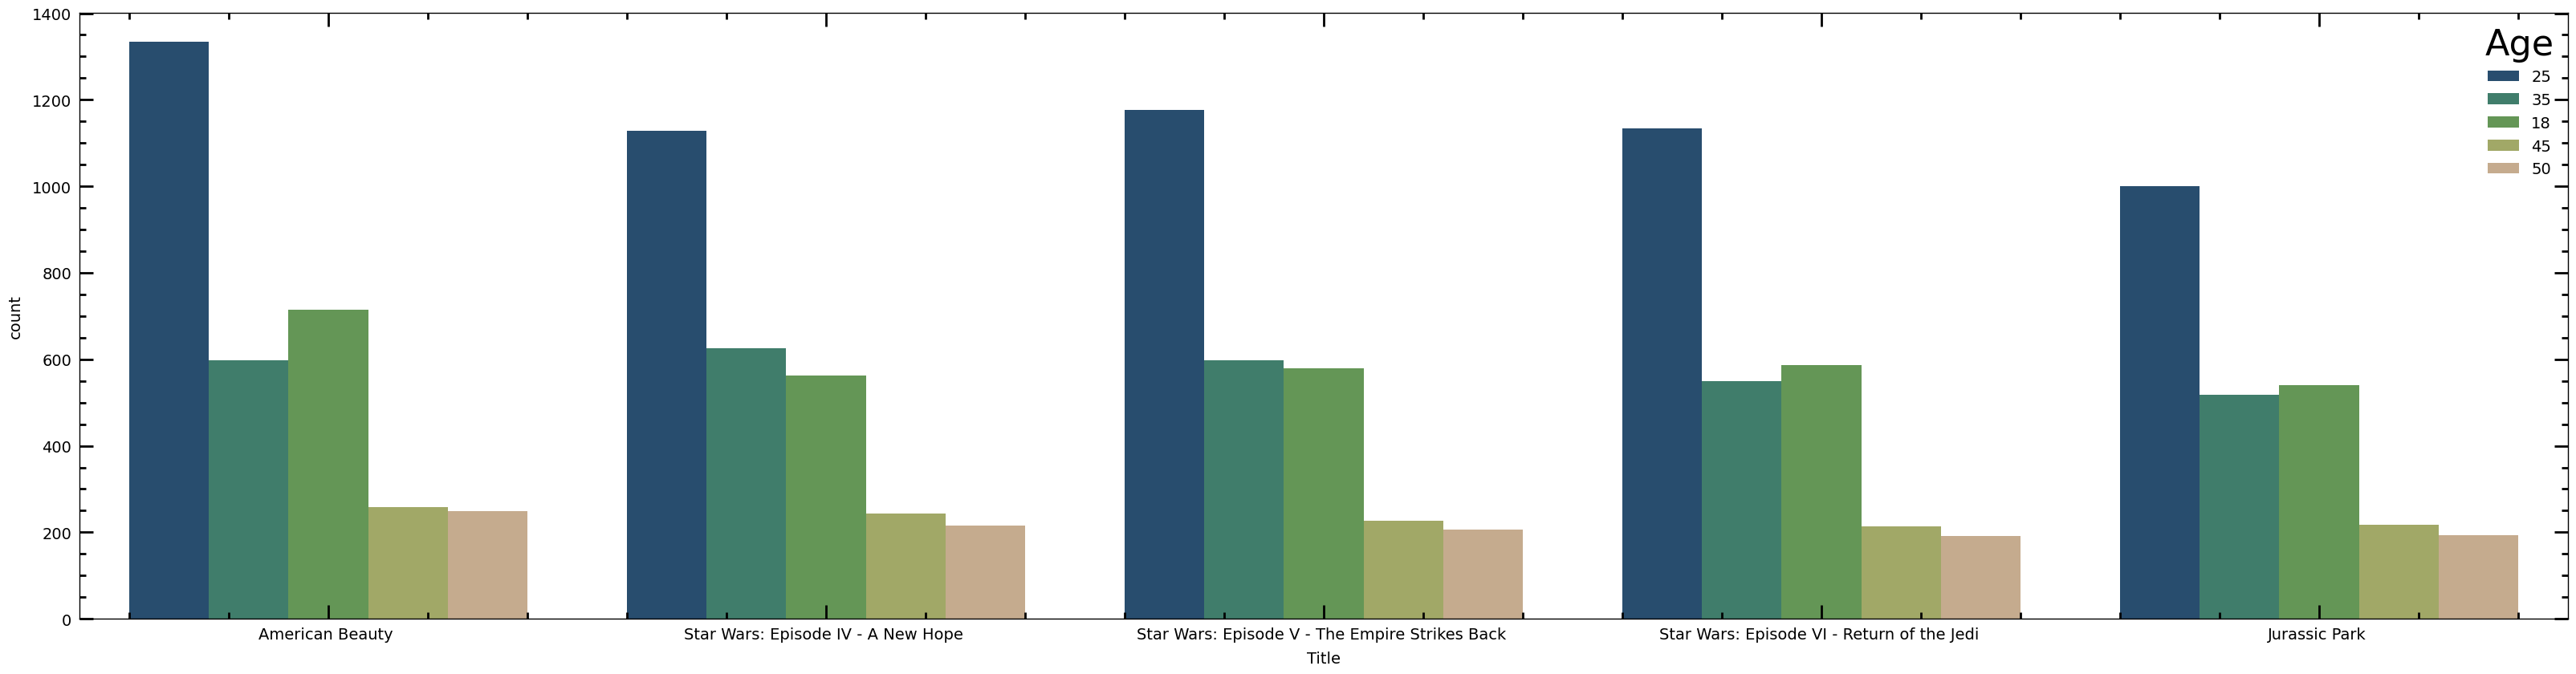

In [ ]:
# Title vs Gender -
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Title", order=df['Title'].value_counts().index[:5], hue="Age", palette="gist_earth", hue_order=df['Age'].value_counts().index[:5])
plt.show()

##<font color="red" face='georgia'>Observations</font>

1. American Beauty is the most watched film by 25-34, follwed by 18-24 and 35-44.
2. Stars Episode IV, V, VI, and Jurassic Park are watched in equal proportion by all the age groups.

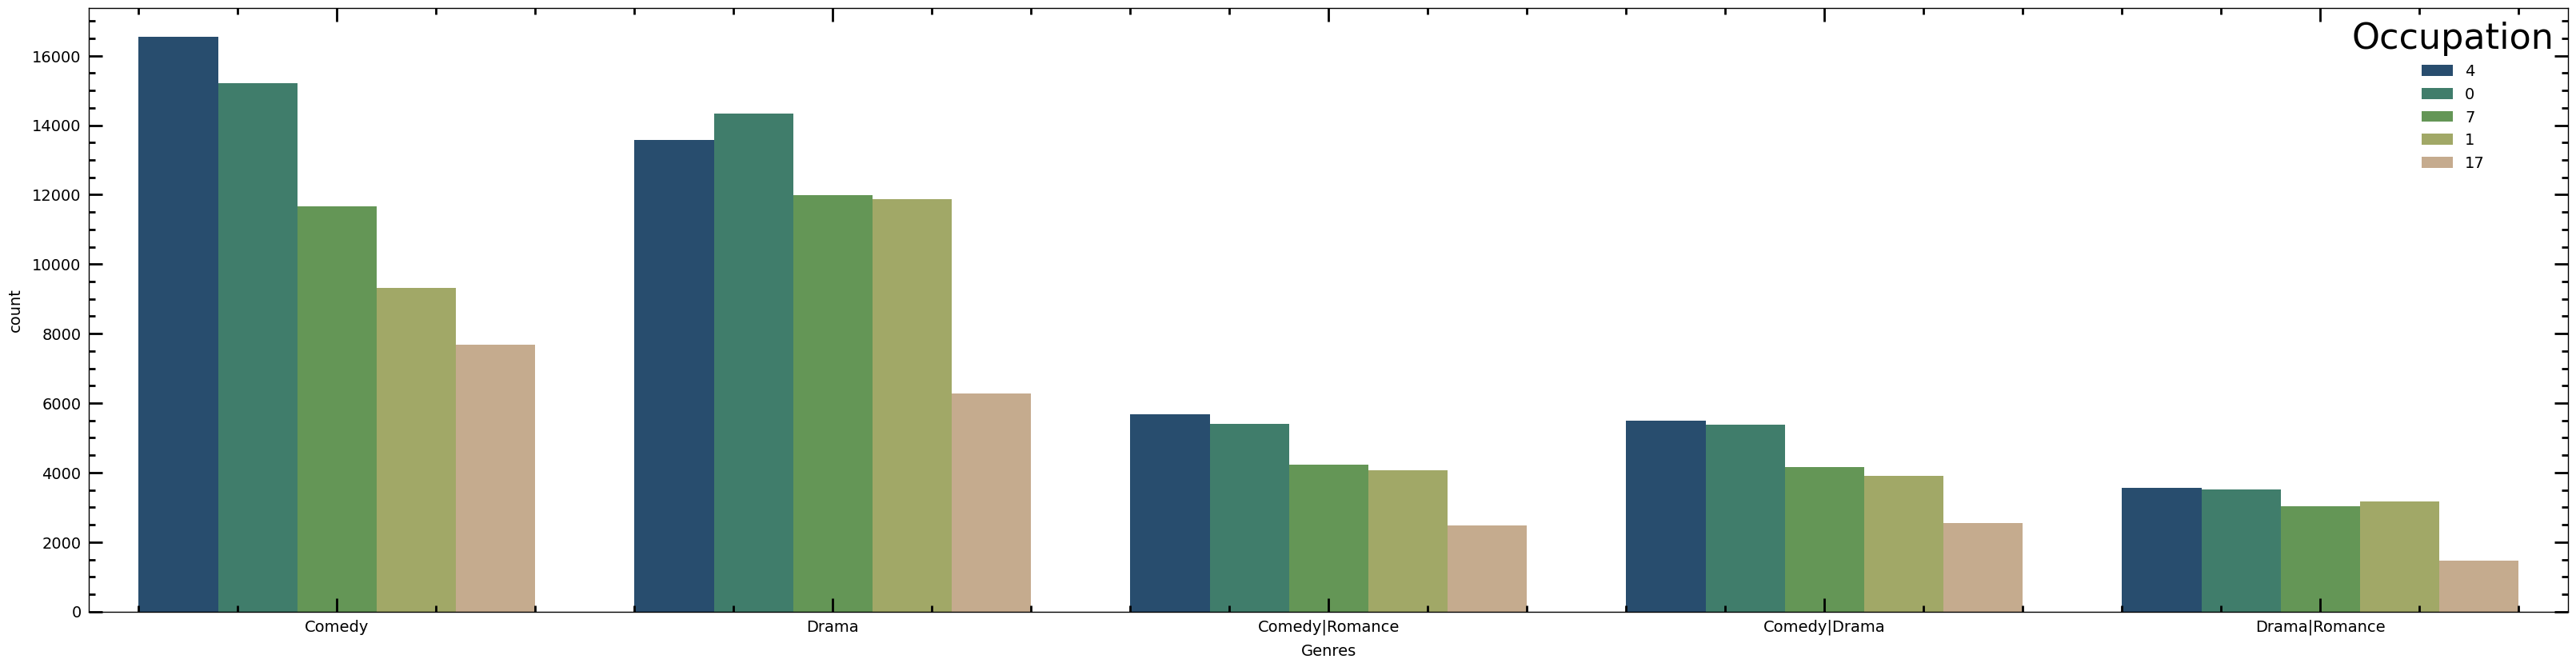

In [ ]:
# Title vs Gender -
plt.figure(figsize=(20, 5))
sns.countplot(data=df, x="Genres", order=df['Genres'].value_counts().index[:5], hue="Occupation", 
              palette="gist_earth", hue_order=df['Occupation'].value_counts().index[:5])
plt.show()

##<font color="red" face='georgia'>Observations</font>

1. The comedy genre is the most popular among college/graduate students and "other" viewers.
2. The drama genre is most watched in equal proportion by executives/managers and academics/educators.

#```Build a Recommender System based on Pearson Correlation```

In [ ]:
!pip3 install scikit-surprise
!pip install --upgrade --user setuptools==58.3.0

In [ ]:
pd.pivot_table(data=df, index='UserID', columns="Title", values="Rating", fill_value=0)

Title   $1,000,000 Duck   'Night Mother   'Til There Was You   'burbs, The   \
UserID                                                                        
1                      0               0                    0             0   
2                      0               0                    0             0   
3                      0               0                    0             0   
4                      0               0                    0             0   
5                      0               0                    0             0   
...                  ...             ...                  ...           ...   
6036                   0               3                    0             0   
6037                   0               0                    0             0   
6038                   0               0                    0             0   
6039                   0               0                    0             0   
6040                   0               0                    0             0   

Title   ...And Justice for All   1-900   10 Things I Hate About You   \
UserID                                                                 
1                             0       0                            0   
2                             0       0                            0   
3                             0       0                            0   
4                             0       0                            0   
5                             0       0                            0   
...                         ...     ...                          ...   
6036                          0       0                            2   
6037                          0       0                            0   
6038                          0       0                            0   
6039                          0       0                            0   
6040                          0       0                            0   

Title   101 Dalmatians   12 Angry Men   13th Warrior, The   ...  \
UserID                                                      ...   
1                   0.0              0                   0  ...   
2                   0.0              0                   0  ...   
3                   0.0              0                   0  ...   
4                   0.0              0                   0  ...   
5                   0.0              0                   0  ...   
...                 ...            ...                 ...  ...   
6036                4.0              0                   1  ...   
6037                0.0              4                   0  ...   
6038                0.0              0                   0  ...   
6039                0.0              0                   0  ...   
6040                0.0              5                   0  ...   

Title   Young Poisoner's Handbook, The   Young Sherlock Holmes   \
UserID                                                            
1                                     0                       0   
2                                     0                       0   
3                                     0                       0   
4                                     0                       0   
5                                     0                       0   
...                                 ...                     ...   
6036                                  0                       3   
6037                                  0                       0   
6038                                  0                       0   
6039                                  0                       3   
6040                                  0                       0   

Title   Young and Innocent   Your Friends and Neighbors   Zachariah   \
UserID                                                                 
1                         0                            0           0   
2                         0                            0           0   
3  

##<font color="red" face='georgia'>SurPRISE</font>

[SurPRISE](https://surpriselib.com/) stands for Simple Python RecommendatIon System Engine

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

In [ ]:
# importing required packages - 
from surprise.similarities import cosine, pearson
from surprise import Dataset, NormalPredictor, Reader
from surprise import KNNWithMeans, KNNWithZScore
from surprise.model_selection import train_test_split

In [ ]:
# creating dataset containing only UserID, MovieID & Rating - 
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["UserID", "MovieID", "Rating"]], reader)

In [ ]:
# Spliting into traing and test - 
trainset, testset = train_test_split(data, test_size=.15)

In [ ]:
# Item - Based Recommender System - 
algo = KNNWithZScore(sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
# query movie
query_movie = "Liar Liar "
# find movie ID 
movie_id = df[df['Title'] == query_movie]['MovieID'].reset_index().iloc[0, 1]

##<font color="red" face='georgia'>Observations</font>

According to ```KNNWithZScore (Pearson)```, top 5 movies similar to ```Liar Liar``` are following

In [ ]:
tsr_inner_id = algo.trainset.to_inner_iid(movie_id) #Considering the movie ID of Liar Liar

tsr_neighbors = algo.get_neighbors(tsr_inner_id, k=5) #Getting the 5 nearest neighbors for movieId of Liar Liar

df[df['MovieID'].isin([algo.trainset.to_raw_iid(inner_id)
                       for inner_id in tsr_neighbors])].drop(['UserID', 'Timestamp', 'Rating',
                                                              'Gender', 'Age', 'Release_Year', 'UserAvgRating', 
                                                              'MovieAvgRating', 'Occupation', "Zip", "Genres"], axis=1).drop_duplicates() #Displaying the 5 nearest neighbors to the Toy Story.

MovieID                                            Title
841599     1450   Prisoner of the Mountains (Kavkazsky Plennik) 
841851     2341                             Dancing at Lughnasa 
939650     3796  Wisdom of Crocodiles, The (a.k.a. Immortality) 
990396     1076                                  Innocents, The 
990563     3333                   Killing of Sister George, The

#```Build a Recommender System based on Cosine Similarity```

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
df['Rating'] = df['Rating'].astype(int)
df['UserID'] = df['UserID'].astype(int)
df['MovieID'] = df['MovieID'].astype(int)
sparse_matrix = csr_matrix((df['Rating'].values, (df['UserID'].values, df['MovieID'].values)))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

#```Item-Item Cosine Similarity Matrix```

In [ ]:
movie_movie_simi = cosine_similarity(X=sparse_matrix.T, dense_output=True)
movie_movie_simi

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.39034871, ..., 0.09347942, 0.04282933,
        0.18269056],
       [0.        , 0.39034871, 1.        , ..., 0.08701306, 0.02606255,
        0.12218461],
       ...,
       [0.        , 0.09347942, 0.08701306, ..., 1.        , 0.20280851,
        0.2346385 ],
       [0.        , 0.04282933, 0.02606255, ..., 0.20280851, 1.        ,
        0.19297221],
       [0.        , 0.18269056, 0.12218461, ..., 0.2346385 , 0.19297221,
        1.        ]])

#```User-User Cosine Similarity Matrix```

In [ ]:
user_user_simi = cosine_similarity(X=sparse_matrix, dense_output=True)
user_user_simi

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.09638153, ..., 0.        , 0.17683395,
        0.13476531],
       [0.        , 0.09638153, 1.        , ..., 0.06611767, 0.06730638,
        0.22019558],
       ...,
       [0.        , 0.        , 0.06611767, ..., 1.        , 0.16377988,
        0.10017352],
       [0.        , 0.17683395, 0.06730638, ..., 0.16377988, 1.        ,
        0.21985662],
       [0.        , 0.13476531, 0.22019558, ..., 0.10017352, 0.21985662,
        1.        ]])

##<font color="red" face='georgia'>Observations</font>

According to ```Cosine Similarity```, top 5 movies similar to ```Liar Liar``` are following

In [ ]:
movie_ids = df['MovieID'].unique()
similar_movies = dict()
for movie in movie_ids:
    # get the top similar movies and store them in the dictionary
    sim_movies = movie_movie_simi[movie].ravel().argsort()[::-1][1:]
    similar_movies[movie] = sim_movies[:5]

# just testing similar movies for American Beauty
df[df['MovieID'].isin(similar_movies[movie_id])][['MovieID', 'Title', 'Genres']].drop_duplicates()

MovieID                        Title             Genres
268895      344  Ace Ventura: Pet Detective              Comedy
277878      231               Dumb & Dumber              Comedy
297433      500              Mrs. Doubtfire              Comedy
432034      586                  Home Alone   Children's|Comedy
617091     3253               Wayne's World              Comedy

In [ ]:
# query movie
query_user = 100
# find movie ID 
user_id = df[df['UserID'] == query_user]['UserID'].reset_index().iloc[0, 1]

##<font color="red" face='georgia'>Observations</font>

According to ```Cosine Similarity```, top 5 users similar to ```UserID=100``` are following

In [ ]:
user_ids = df['UserID'].unique()
similar_users = dict()
for user in user_ids:
    # get the top similar movies and store them in the dictionary
    sim_users = user_user_simi[user].ravel().argsort()[::-1][1:]
    similar_users[user] = sim_users[:5]

# just testing similar users for UserID 100
df[df['UserID'].index.isin(similar_users[user_id])][['UserID', 'Title', 'Genres']].drop_duplicates()

UserID                             Title                        Genres
729     2684  One Flew Over the Cuckoo's Nest                          Drama
778     2866  One Flew Over the Cuckoo's Nest                          Drama
2186    4591        James and the Giant Peach   Animation|Children's|Musical
4020    3857                  Erin Brockovich                          Drama
4706    5504                    Bug's Life, A    Animation|Children's|Comedy

#```Recommendations using Nearest Neighbors algorithms```

In [ ]:
from sklearn.neighbors import NearestNeighbors
%timeit
nn = NearestNeighbors(algorithm='ball_tree')
nn.fit(movie_movie_simi)
distances, indices = nn.kneighbors(movie_movie_simi)

##<font color="red" face='georgia'>Observations</font>

According to ```Nearest Neighbor Algorithm```, top 5 movies similar to ```Liar Liar``` are following

In [ ]:
# indices[movie_id]
df[df['MovieID'].isin(indices[movie_id])][['MovieID', 'Title',]].drop_duplicates()[1:6]

MovieID                        Title
268895      344  Ace Ventura: Pet Detective 
277878      231               Dumb & Dumber 
297433      500              Mrs. Doubtfire 
432034      586                  Home Alone

#```Build a Recommender System based on Matrix Factorization```

In [ ]:
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate

In [ ]:
svd = SVD(n_factors=4)
# svd.fit(data)
# cross_validate()
cross_validate(svd, data, measures=['rmse','mae'], cv = 5 , return_train_measures=True,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8821  0.8806  0.8831  0.8803  0.8781  0.8808  0.0017  
MAE (testset)     0.6959  0.6939  0.6967  0.6943  0.6923  0.6946  0.0016  
RMSE (trainset)   0.8539  0.8537  0.8568  0.8516  0.8499  0.8532  0.0023  
MAE (trainset)    0.6749  0.6738  0.6767  0.6721  0.6706  0.6736  0.0021  
Fit time          9.02    9.45    9.65    9.53    12.33   9.99    1.19    
Test time         2.61    3.08    2.55    2.61    2.43    2.66    0.22    


{'test_rmse': array([0.88208088, 0.88062677, 0.88310484, 0.8802522 , 0.8781498 ]),
 'train_rmse': array([0.85394371, 0.85369259, 0.85677074, 0.85162008, 0.84988283]),
 'test_mae': array([0.69588137, 0.69387318, 0.69673047, 0.69427113, 0.6923045 ]),
 'train_mae': array([0.67486622, 0.67375438, 0.67665679, 0.67214064, 0.67055399]),
 'fit_time': (9.016021490097046,
  9.446160793304443,
  9.654369831085205,
  9.5311439037323,
  12.325315952301025),
 'test_time': (2.6078951358795166,
  3.0846173763275146,
  2.5481135845184326,
  2.606102705001831,
  2.4305338859558105)}

The above data gives the RMSE and MAE values for each fold as well as average value and standard deviation value.

- ```test_rmse``` represents the rmse values of testsets.

- ```train_rmse``` represents the rmse values of trainsets.

- similarly, ```test_mae``` and ```train_mae``` represents MAE values of train and testsets.

- ```fit_time``` represents time taken to fit the trainsets.

- ```test_time``` represents time taken to fit the testsets.

In [ ]:
svd.fit(trainset)

In [ ]:
predictions = svd.test(testset)

In [ ]:
# Evaluate SVD model
print('SVD - RMSE:', accuracy.rmse(predictions, verbose=False))
print('SVD - MAE:', accuracy.mae(predictions, verbose=False))

SVD - RMSE: 0.8813128705641542
SVD - MAE: 0.6943682731579096


In [ ]:
svd.pu.shape , svd.qi.shape #pu gives the embeddings of Users and qi gives the embeddings of Items.

((6040, 4), (3661, 4))

In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n_users = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n_users[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for (uid, user_ratings) in top_n_users.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n_users[uid] = user_ratings[:n]

    return top_n_users

In [ ]:
top_n_users = get_top_n(predictions, n=5)

# # Print the recommended items for each user
# for uid, user_ratings in top_n.items():
#     print(uid, [iid for (iid, _) in user_ratings])

##<font color="red" face='georgia'>Observations</font>

According to ```SVD```, top 5 movies similar to ```Liar Liar``` are following

In [ ]:
df[df['MovieID'].isin(np.array(top_n_users[user_id])[:, 0].astype(int).tolist())][['Title']].drop_duplicates()

Title
52255                  Saving Private Ryan 
74398                           GoodFellas 
96090                           Braveheart 
183397             Godfather: Part II, The 
201055  Indiana Jones and the Last Crusade

In [ ]:
# d = 2
svd_d2 = SVD(n_factors=2)
svd_d2.fit(trainset)

In [ ]:
svd_d2.pu.shape , svd_d2.qi.shape #pu gives the embeddings of Users and qi gives the embeddings of Items.

((6040, 2), (3661, 2))

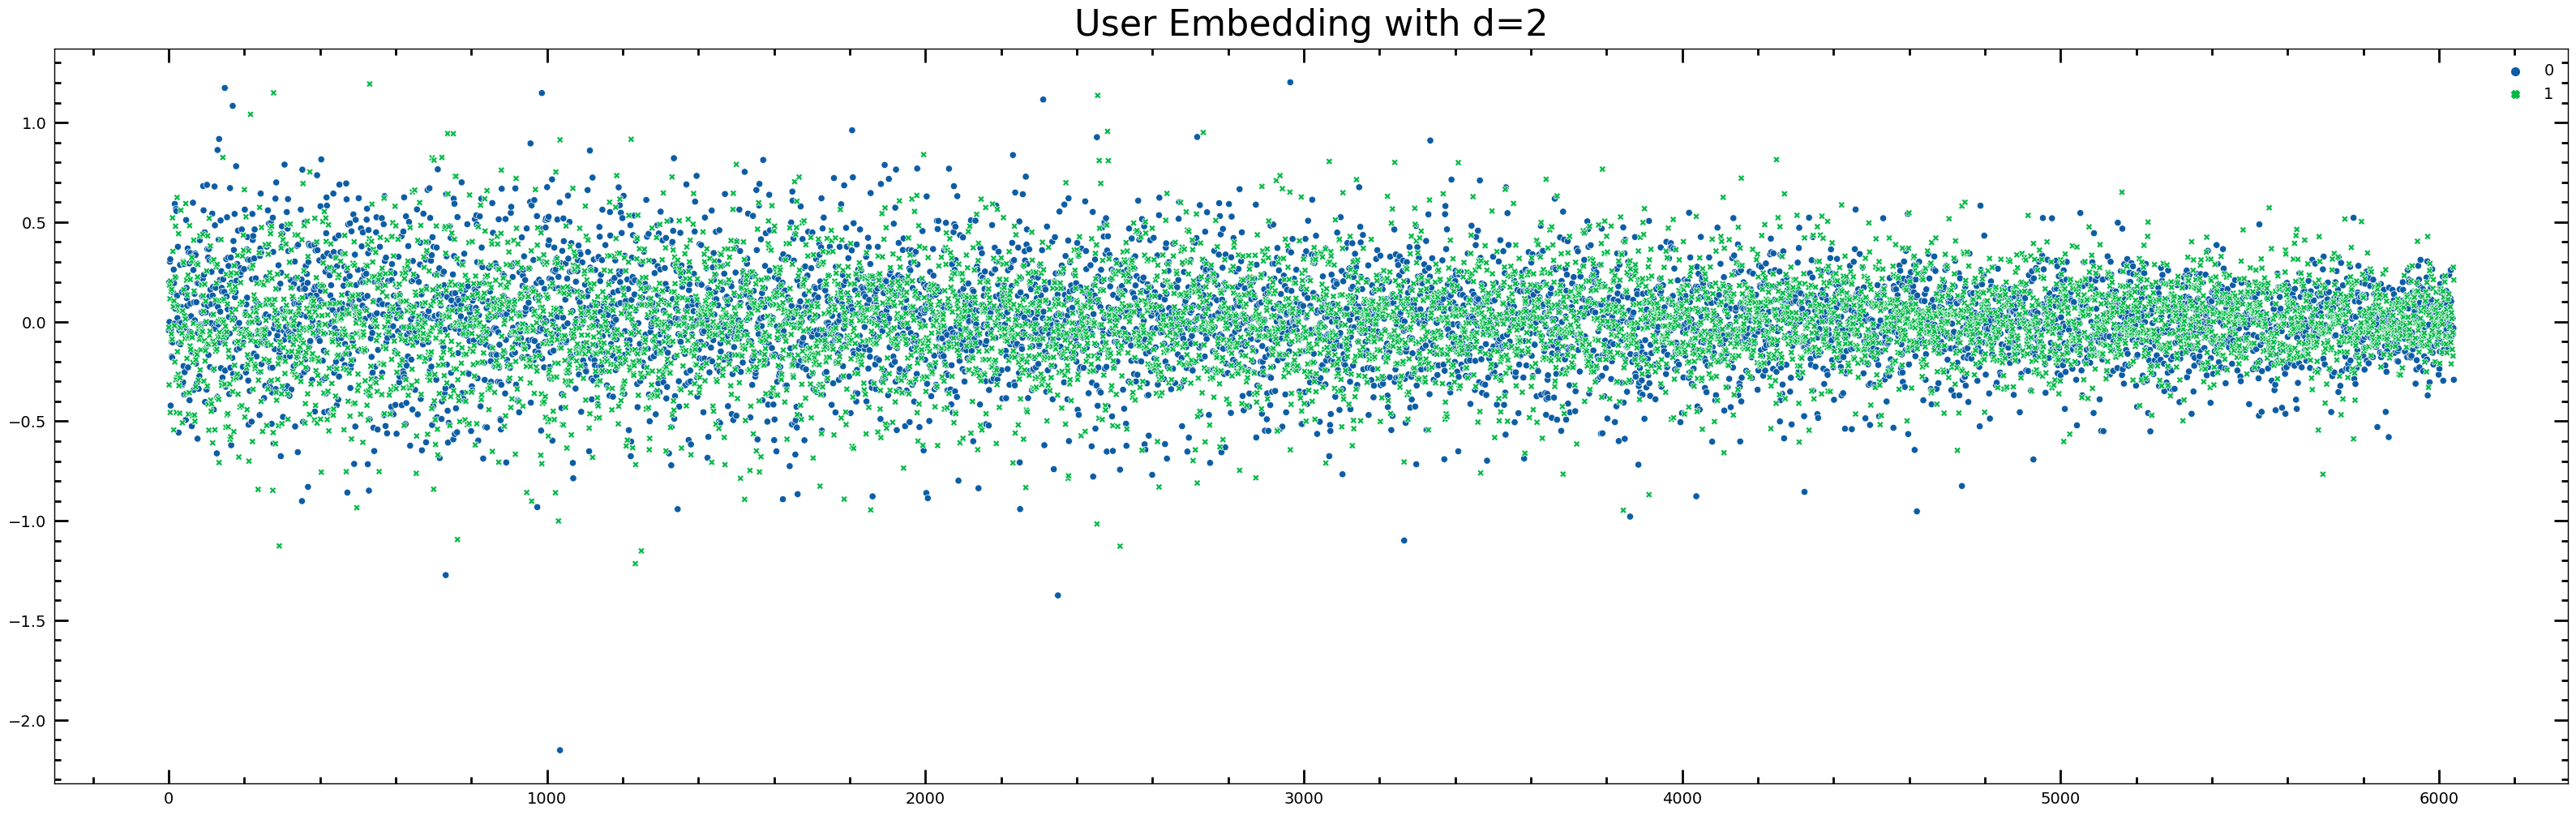

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(svd_d2.pu[:, :])
plt.title("User Embedding with d=2")
plt.show()

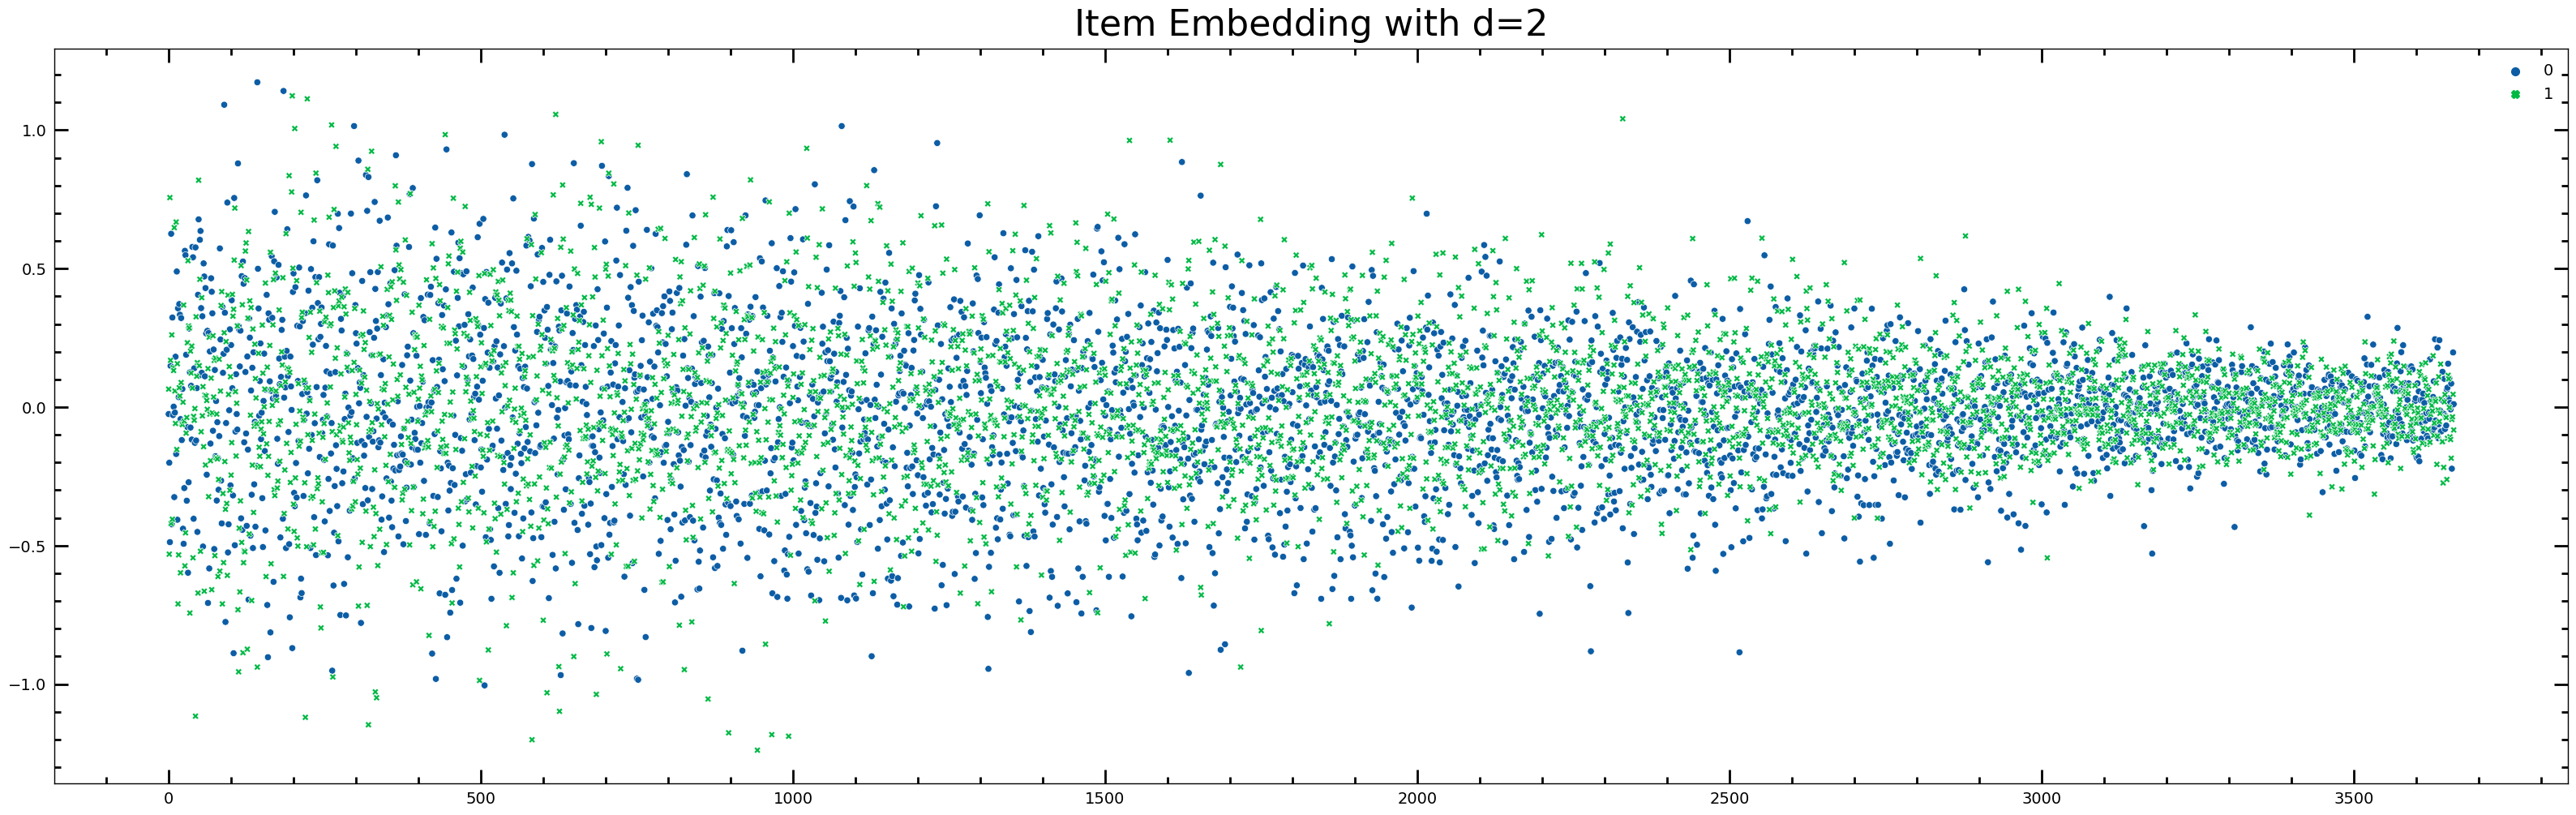

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(svd_d2.qi[:, :])
plt.title("Item Embedding with d=2")
plt.show()

#```Build a Recommender System based Pearson Correlation  - User (Optional)```

In [ ]:
algo_user = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': True})
algo_user.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


##<font color="red" face='georgia'>Observations</font>

According to ```Pearson Correlation (User)```, top 5 users similar to ```UserID=100``` are following

In [ ]:
tsr_inner_id = algo_user.trainset.to_inner_uid(user_id) #Considering the UserID

tsr_neighbors = algo_user.get_neighbors(tsr_inner_id, k=5) #Getting the 5 nearest neighbors for movieId of American Beauty

temp_df = df[df['UserID'].isin([algo_user.trainset.to_raw_iid(inner_id)
                       for inner_id in tsr_neighbors])].drop(['Timestamp', 'Rating',
                                                              'Gender', 'Age', 'Release_Year', 'UserAvgRating', 
                                                              'MovieAvgRating', 'Occupation', "Zip", "Genres"], axis=1).drop_duplicates() #Displaying the 5 nearest neighbors to the Toy Story.
temp_df.sort_values("MovieID")[:5]

UserID  MovieID                   Title
43266      215        1              Toy Story 
605714    3060       16                 Casino 
423776    1963       17  Sense and Sensibility 
791978    3060       22                Copycat 
330375     215       24                 Powder